# Pandas dataframes

In [250]:
import pandas as pd

filename = 'coma_z_df.hdf'
results_df = pd.read_hdf(filename)

In [251]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11580 entries, 0 to 11579
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ra      11580 non-null  float64
 1   dec     11580 non-null  float64
 2   z       11580 non-null  float64
dtypes: float64(3)
memory usage: 361.9 KB


## Exploring data

In [252]:
results_df.describe()

,ra,dec,z
count,11580.000000,11580.000000,1.158000e+04
mean,194.792484,28.497571,9.740559e-03
std,4.893065,4.387377,1.285723e-02
min,185.904180,19.981245,4.679875e-08
25%,190.700790,25.078895,1.308081e-04
50%,194.638050,28.467779,4.897517e-04
75%,199.001942,32.208117,2.272564e-02
max,204.011840,35.980753,3.997859e-02


#### Exercise

Review the summary statistics in this table.

    1. Do the values make sense based on what you know about the context?

    2. Do you see any values that seem problematic, or evidence of other data issues?



## Adding a column

In [253]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Coma center and systemic velocity
center = SkyCoord("12h59m48.7s +27d58m50s", frame='icrs')
z0 = 0.0231

galaxies = SkyCoord(results_df['ra'].values * u.degree,results_df['dec'].values * u.degree, frame='icrs')
sep = galaxies.separation(center)

results_df['separation'] = sep
results_df

,ra,dec,z,separation
0,203.93122,33.560902,0.026484,9.514325
1,203.97255,33.634705,0.024760,9.583860
2,203.92797,34.063352,0.039756,9.798426
3,203.91794,33.877849,0.024818,9.683860
4,203.86190,33.725040,0.023432,9.558361
...,...,...,...,...
11575,203.73511,34.165741,0.000032,9.731031
11576,203.68167,34.026783,0.000005,9.612274
11577,203.73912,34.044758,0.023833,9.661221
11578,204.00092,33.665516,0.000330,9.620618


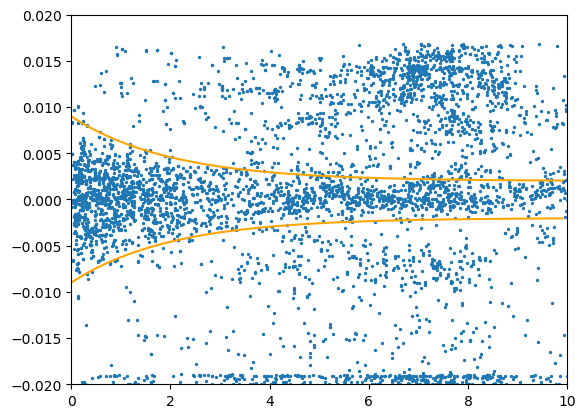

In [254]:
import matplotlib.pyplot as plt
import numpy as np

z = results_df['z'].values

plt.scatter(sep, z-z0,s=2)
plt.ylim(-0.02,0.02)

x = np.arange(0,10,0.1)
y = 0.007 * np.exp(-x*0.5)+0.002
plt.ylim(-0.02,0.02)
plt.xlim(0,10)
plt.plot(x,y,color='orange')
#plt.plot(x,0.009-x*0.0007,color='red')
#plt.plot(x,-(0.009-x*0.0007),color='red')
plt.plot(x,-y,color='orange')
plt.show()

In [255]:
sep = results_df['separation'].values.value
type(sep)


numpy.ndarray

0.0231


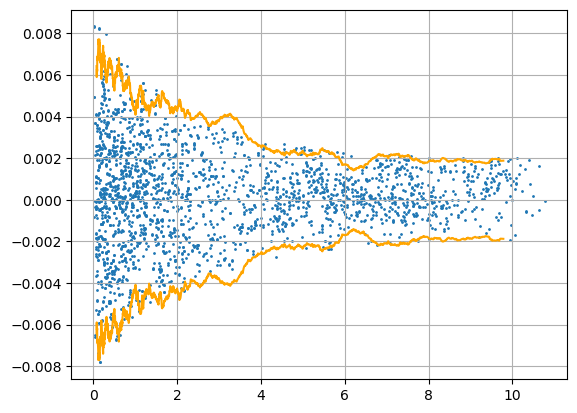

In [256]:
# Refine by computing velocity dispersion

z0 = 0.0231
z = results_df['z'].values
sep = results_df['separation'].values.value


ysep = 0.007 * np.exp(-sep * 0.5)+0.002
#ysep = 0.008 - sep * 0.0007
y = z - z0
idx = np.abs(y) < ysep


ra, dec = results_df['ra'].values[idx], results_df['dec'].values[idx]
#z0 = np.nanmedian(z[sep < 2])
print(z0)
z = (z-z0)[idx]
d = sep[idx]

sidx = np.argsort(d)

d = d[sidx]
z = z[sidx]
ra = ra[sidx]
dec = dec[sidx]

window = 80
zw = np.lib.stride_tricks.sliding_window_view(z, window)
zvar = np.nanstd(zw, axis=-1)
zmed = np.nanmedian(zw, axis=-1)
#zwm = zw.copy()
#for zwm_ , zmed_ in zip(zwm, zmed):
#    zwm_ = np.abs(zwm_ - zmed_)
#zmad = np.nanmedian(zwm, axis=-1)
dw = np.lib.stride_tricks.sliding_window_view(d, window)
dvar = np.mean(dw, axis=-1)
plt.scatter(d,z,s=1)
plt.plot(dvar, 2.0*zvar,color='orange')
plt.plot(dvar, -2.0*zvar,color='orange')
plt.grid()

In [257]:
# Fit of the empirical curve with exponential
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a*np.exp(-b*x)+c

popt, pcov = curve_fit(func, dvar, 2.0*zvar, p0=(0.008, 0.8, 0.004))
print(popt)

[0.00547783 0.36088141 0.00152396]


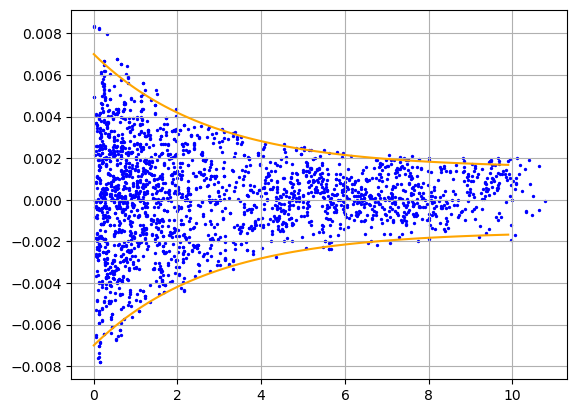

In [258]:
plt.scatter(d,z,color='blue',s=2)
x = np.arange(0,10,0.1)
curve = popt[0]*np.exp(-popt[1]*x) + popt[2]
plt.plot(x, curve, color='orange')
plt.plot(x, -curve, color='orange')
plt.grid()
plt.show()

## Create a mask

In [259]:
mask = np.abs(results_df['z'] - z0) < popt[0]*np.exp(-popt[1]*results_df['separation']) + popt[2]

In [260]:
type(mask)

pandas.core.series.Series

In [261]:
mask.sum()

np.int64(2279)

In [262]:
len(results_df)

11580

In [263]:
cluster_df = results_df[mask]
type(cluster_df)

pandas.core.frame.DataFrame

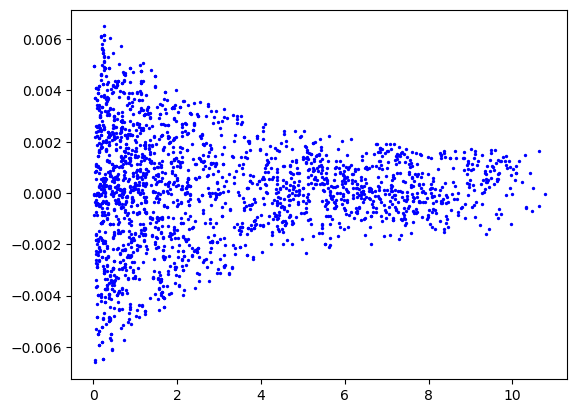

In [264]:
plt.scatter(cluster_df['separation'], cluster_df['z']-z0,s=2,color='blue')

In [265]:
len(cluster_df) / len(results_df)

0.1968048359240069

In [266]:
filename = 'coma_zdata.hdf'
cluster_df.to_hdf(filename, key='cluster_df', mode='w')


### Exercise

1. Compute the velocity of galaxies wrt the systemic velocity of the cluster:  v = c (z - z0) / (1 + z0)
Using c = 299792.458 km/s

2. Compute the angular distance:
   You can use the formula:
   dang [Mpc] = c z0 / H angle(rad)  using H = 70 km/s/Mpc

   Or, more correctly, use the relativistic formula. Find the Mpc/deg conversion from:

    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    arcmin2kpc = cosmo.kpc_proper_per_arcmin(z0)

4. Add v and dang as columns to the cluster_df dataframe.

5. Save the dataframe

6. Plot the v vs dang


In [267]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

deg2Mpc = cosmo.kpc_proper_per_arcmin(z0).to(u.Mpc/u.deg)

c = 299792.458
v = c * (cluster_df['z']-z0) / (1+z0)
dang = cluster_df['separation'] * deg2Mpc
# dang = c * z0 / H * cluster_df['separation'].values * np.pi/180

In [268]:
import pandas as pd
pd.options.mode.chained_assignment = None  # avoid chained assignments warnings

cluster_df['v'] = v
cluster_df['dang'] = dang
cluster_df

,ra,dec,z,separation,v,dang
1,203.97255,33.634705,0.024760,9.583860,486.518825,16.090122
4,203.86190,33.725040,0.023432,9.558361,97.149049,16.047313
7,203.73864,34.044082,0.023648,9.660499,160.641405,16.218790
10,203.64579,33.627982,0.023898,9.355244,233.709773,15.706303
12,203.88015,34.152130,0.024361,9.818970,369.643427,16.484844
...,...,...,...,...,...,...
11525,190.10497,26.524619,0.025526,4.548634,710.857703,7.636597
11548,190.76983,27.716141,0.025082,3.707886,580.854847,6.225084
11559,191.78535,27.793128,0.024833,2.805913,507.830432,4.710784
11567,203.14113,33.561160,0.023351,8.974308,73.569438,15.066760


In [269]:
filename = 'coma_zdata.hdf'
cluster_df.to_hdf(filename, key='cluster_df')

#filename = 'coma_zdata.pkl'
#cluster_df.to_pickle(filename)

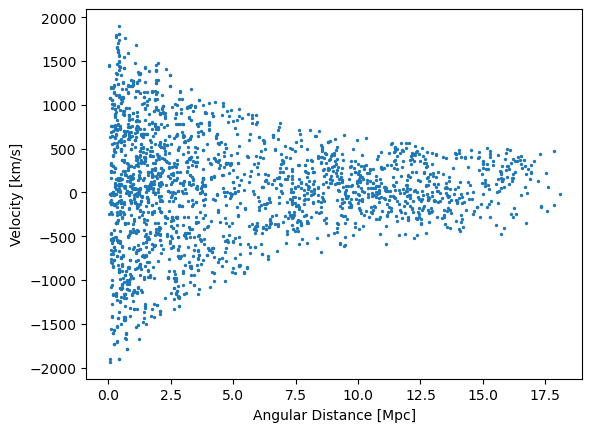

In [270]:
plt.scatter(cluster_df['dang'], cluster_df['v'],s=2)
plt.xlabel('Angular Distance [Mpc]')
plt.ylabel('Velocity [km/s]')
plt.show()